# Removing EOG/EKG artefacts from M/EEG data

## Overview

ICA is a powerful tool for isolating and removing certain types of noise from signals. We will show how this can be done with sample data with MNE-Python. In particular, we focus on EOG and EKG noise. These types of noise are particularly well-suited for removal with ICA, because they usually have a clear, and consistent topographical representation.

**Analysis goals**

1) Perform an Independent Component Analysis (ICA) on a sample M/EEG dataset.
2) Learn to evaluate the properties of components, and identify artefactual ones.
3) Reconstruct M/EEG data after removing artefactual components

**Learning goals**

The MNE-Python ICA class contains everything needed to achieve these goals. The exercise will mostly revolve around you familiarising yourself with it and its methods, notably: ICA.fit(), ICA.plot_components(), ICA.plot_sources(),ICA.find_bads_eog(), ICA.find_bads_ecg, and ICA.apply().

In [1]:
# First make sure the required packages are installed, then import them
import sys
!{sys.executable} -m pip install mne python-picard
import mne
import numpy as np
import os
# specify inline rendering; change "inline" to "qt" for interactivity
%matplotlib inline

---

## Downloading and preparing the dataset



In [2]:
# get the data
sample_data_folder = mne.datasets.sample.data_path()
sample_data_raw_file = os.path.join(
    sample_data_folder, "MEG", "sample", "sample_audvis_filt-0-40_raw.fif"
)
# load data as Raw object
raw = mne.io.read_raw_fif(sample_data_raw_file, preload=True)

# only take first 60 seconds for speed
raw.crop(tmax=60.)
# do a quick high-pass filter, as ICA doesn't like slow drifts...
raw.filter(l_freq=1., h_freq=None)

Opening raw data file /home/jev/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Reading 0 ... 41699  =      0.000 ...   277.709 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 497 samples (3.310 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s


Measurement date,"December 03, 2002 19:01:10 GMT"
Experimenter,Unknown
Participant,Unknown
Digitized points,146 points
Good channels,"203 Gradiometers, 102 Magnetometers, 9 Stimulus, 59 EEG, 1 EOG"
Bad channels,"MEG 2443, EEG 053"
EOG channels,EOG 061
ECG channels,Not available
Sampling frequency,150.15 Hz
Highpass,1.00 Hz
Lowpass,40.00 Hz


---
## Exploring ICA
Let's have a quick look at the data.

Using matplotlib as 2D backend.


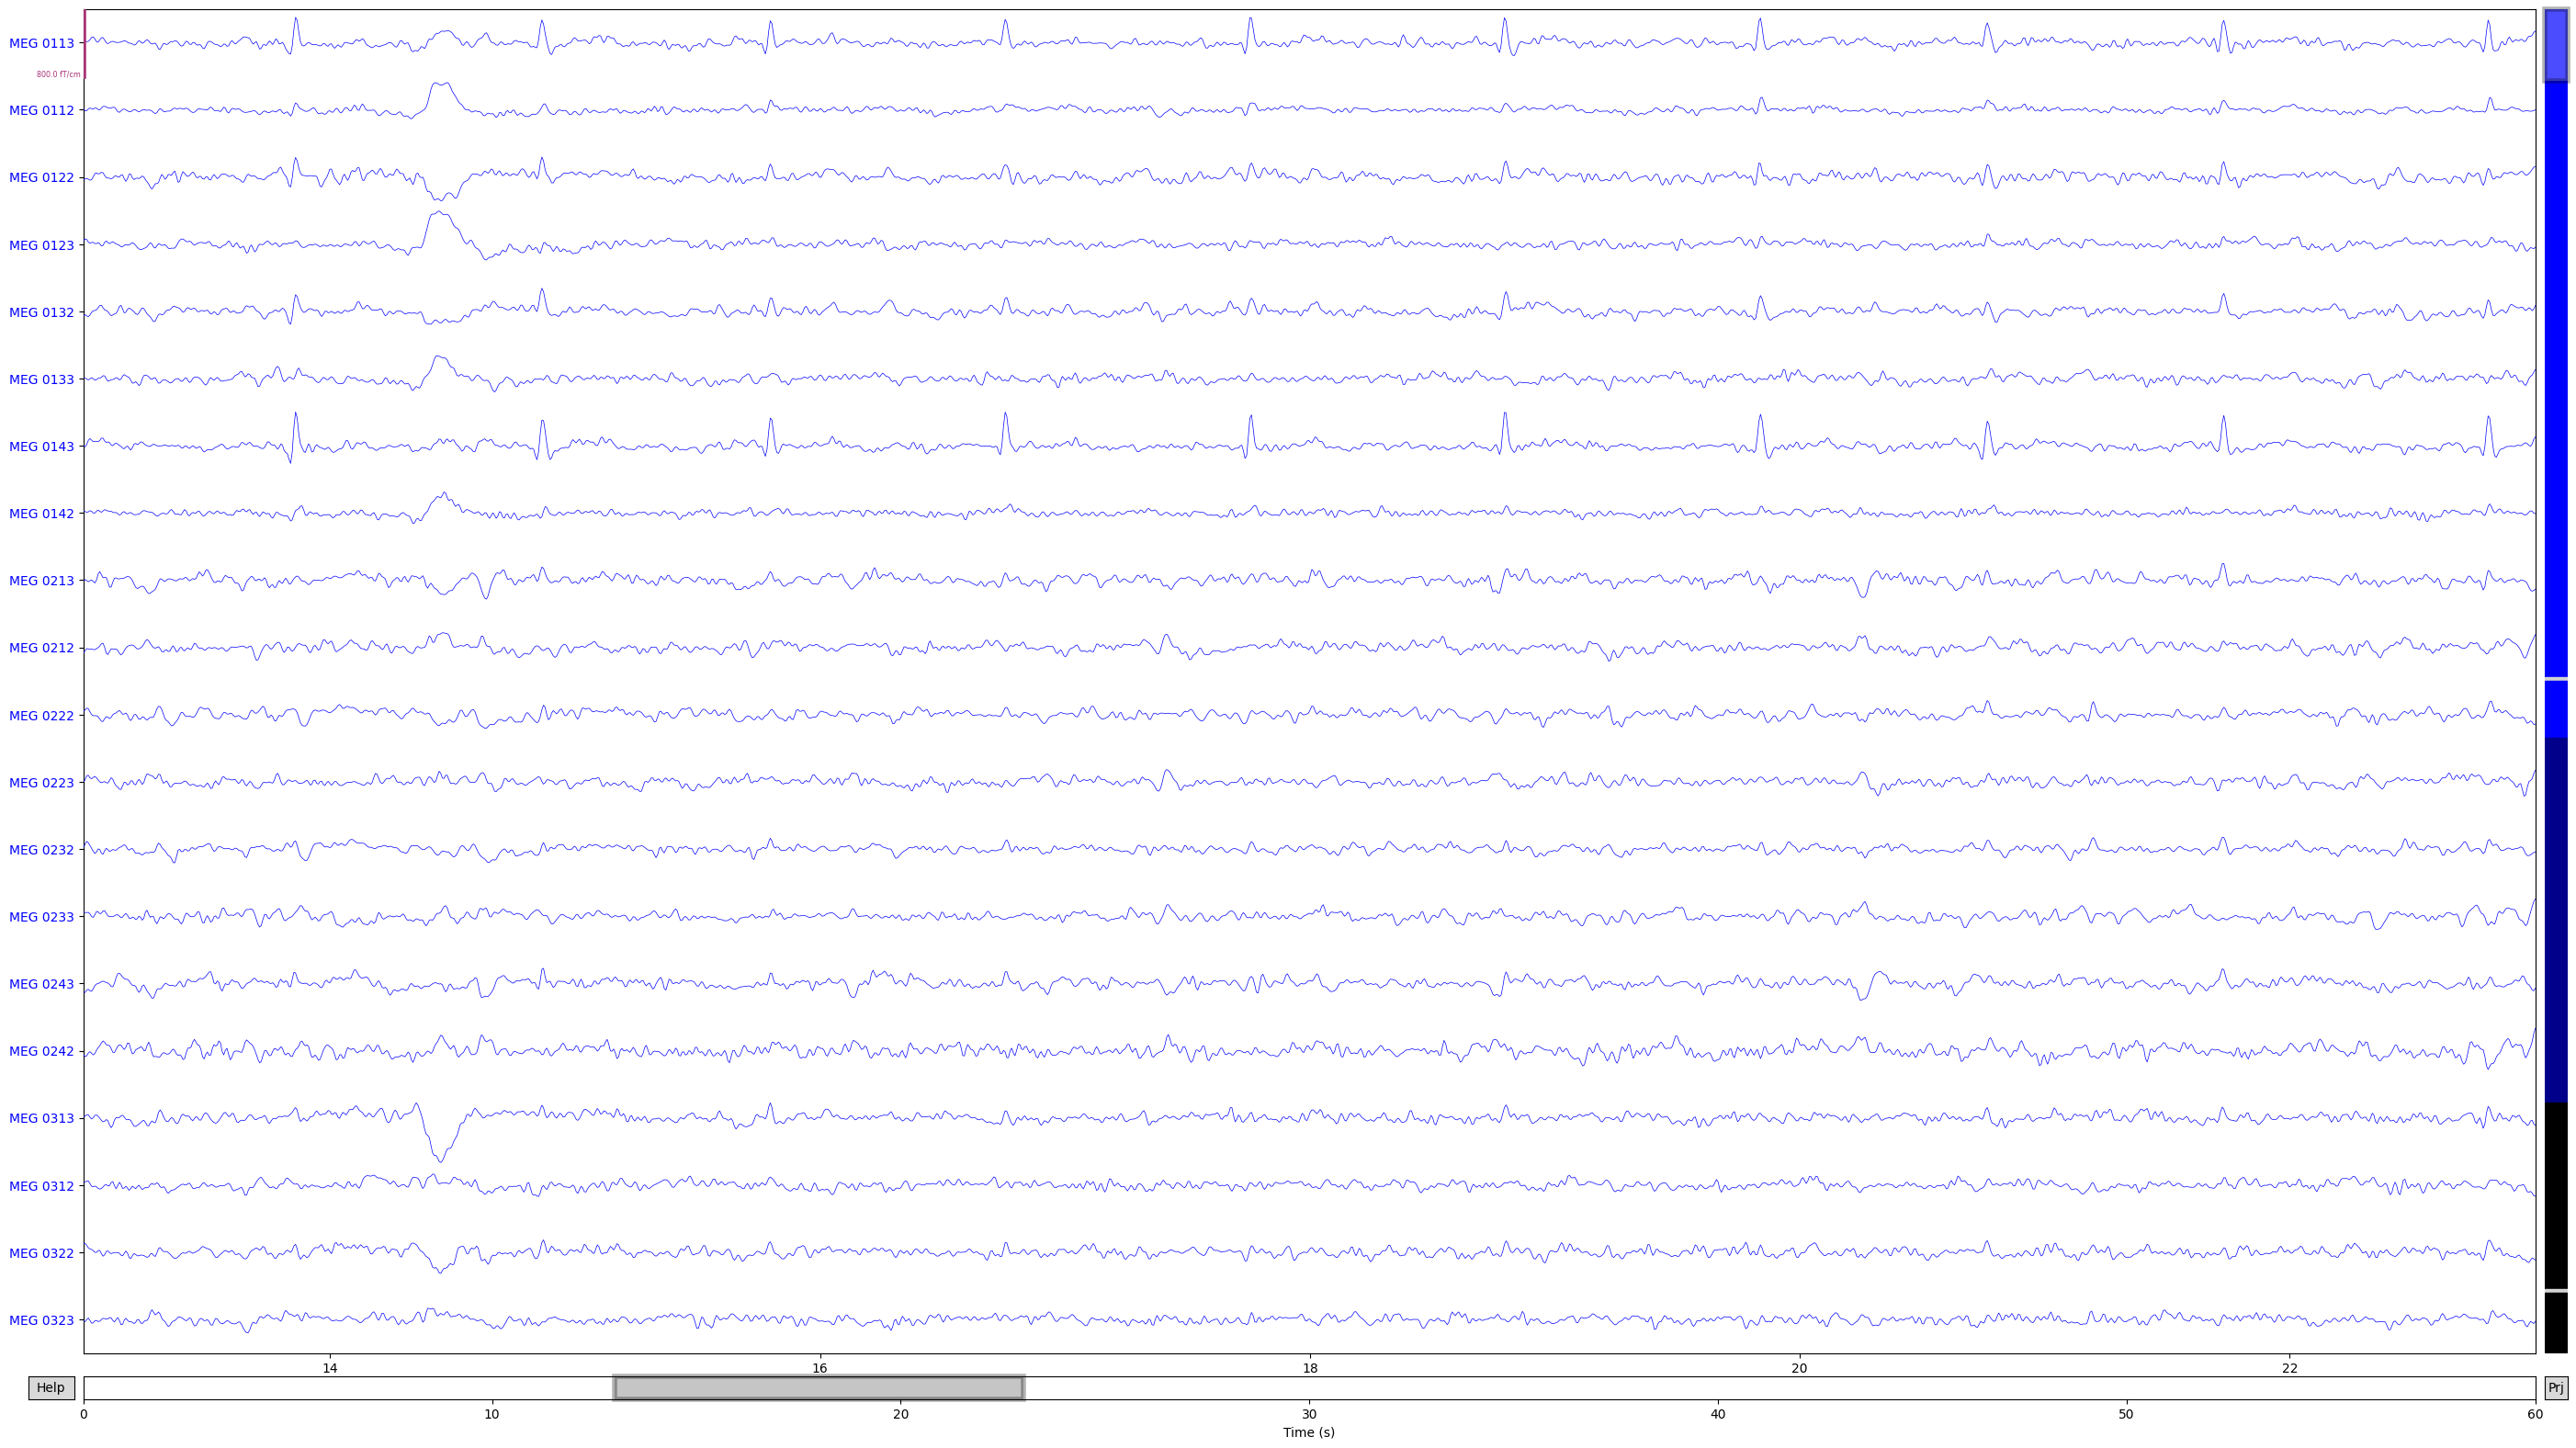

In [3]:
fig = raw.plot(start=13)

Here we can see already very clear heartbeats in the signal. Also, an eyeblink occurs between seconds 14 and 15. Let's see if we can get rid of them. As a first step, we set up an ICA object, and then fit it to the data.

In [4]:
# we initialise it to use the Picard algorithm, also limit ourselves to only 32 components for speed
# ICA is not deterministic, so we specify a random state here to ensure uniformity in the tutorial; this is not generally necessary
ica = mne.preprocessing.ICA(n_components=32, method="picard", random_state=24)
# now fit
ica.fit(raw)

Fitting ICA to data using 364 channels (please be patient, this may take a while)
Selecting by number: 32 components
Fitting ICA took 1.1s.


Method,picard
Fit parameters,max_iter=500
Fit,185 iterations on raw data (9010 samples)
ICA components,32
Available PCA components,364
Channel types,"mag, grad, eeg"
ICA components marked for exclusion,—


We now have 32 components. Each one will have a topography and a time course. We can examine them like this.

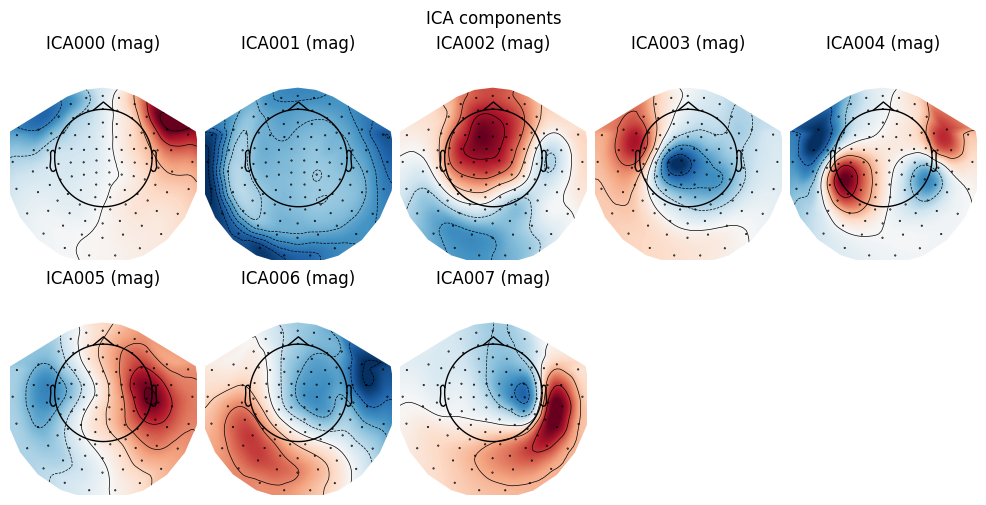

In [5]:
# topographies, just the first 8
fig = ica.plot_components(picks=np.arange(8))

Creating RawArray with float64 data, n_channels=9, n_times=9010
    Range : 6450 ... 15459 =     42.956 ...   102.954 secs
Ready.


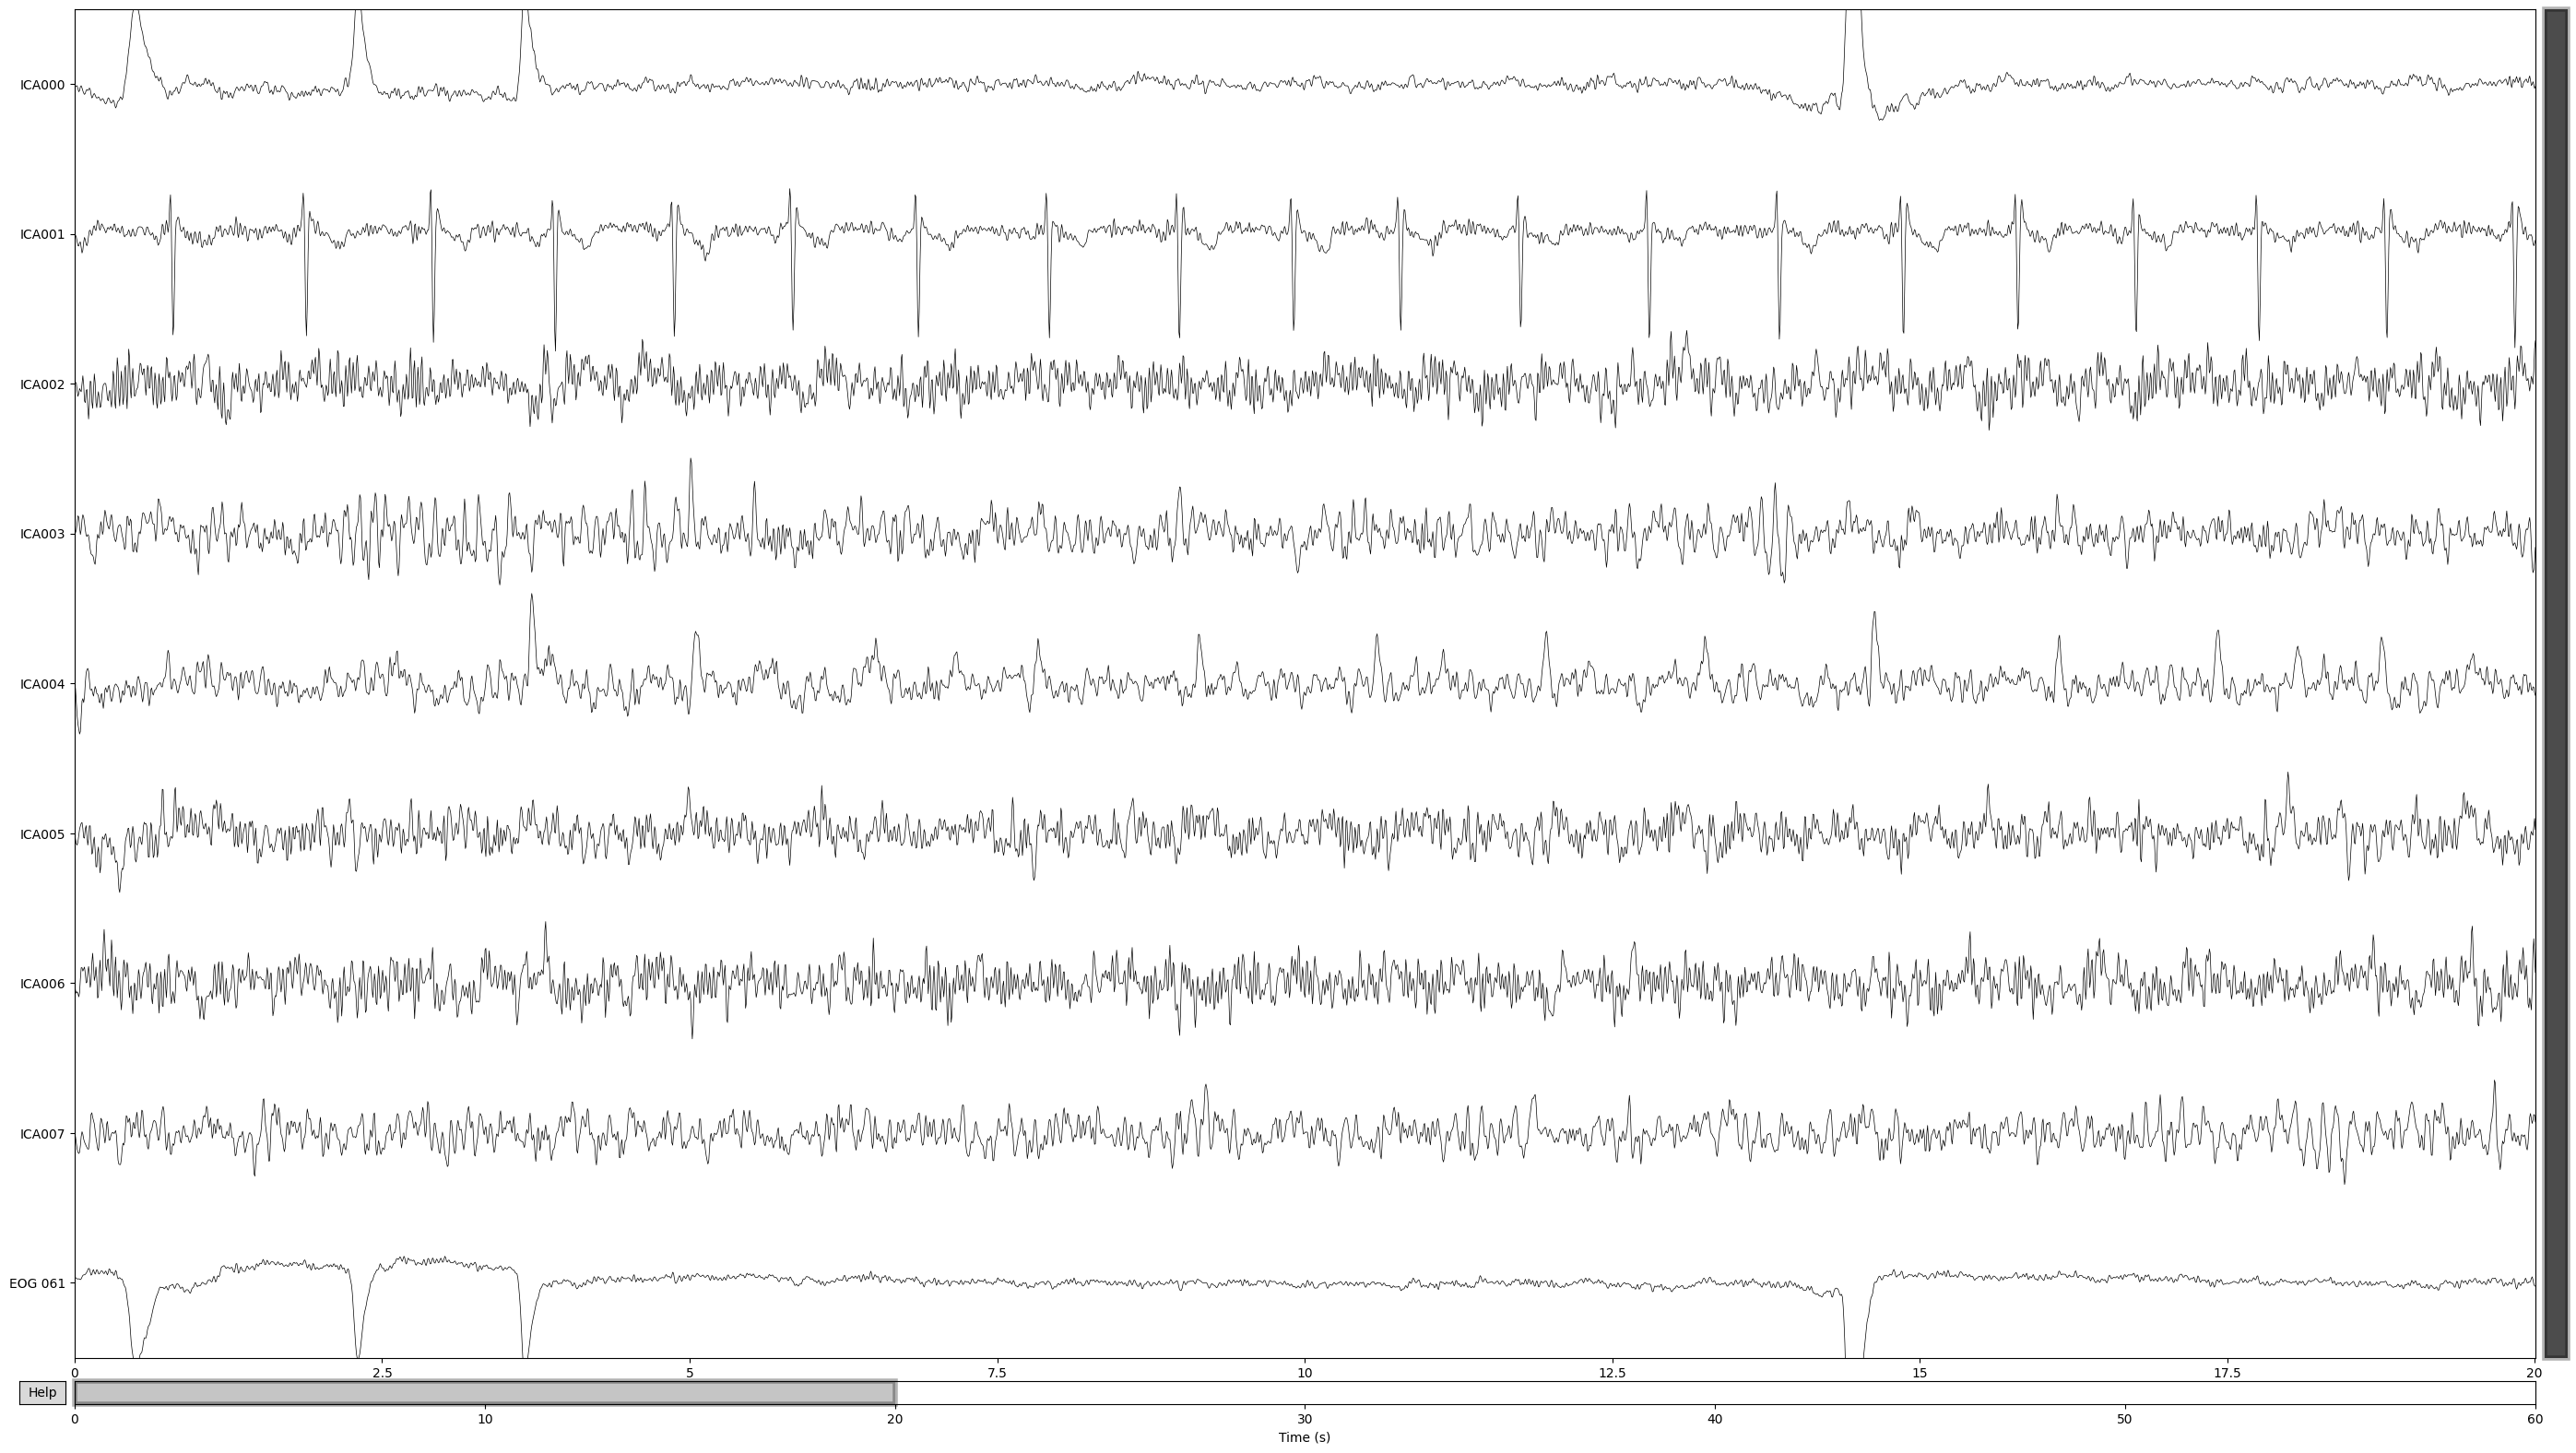

In [6]:
# time courses (sources), just the first 8
fig = ica.plot_sources(raw, np.arange(8))

Looking at both the topographies and time courses together, it seems clear that components 000 and 001 are the respective EOG and ECG components. Note that MNE-Python also helpfully displays the EOG channel, which mirrors component 000 very closely. So the next step is to zero out those components and then rebuild our data, which should then be lacking EOG and EKG noise!

---
## Reconstructing clean data

In [7]:
# reconstruct the data without components 0 and 1
old_raw = raw.copy() # keep this around for comparison in the next step
ica.apply(raw, exclude=[0, 1])

Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 2 ICA components
    Projecting back using 364 PCA components


Measurement date,"December 03, 2002 19:01:10 GMT"
Experimenter,Unknown
Participant,Unknown
Digitized points,146 points
Good channels,"203 Gradiometers, 102 Magnetometers, 9 Stimulus, 59 EEG, 1 EOG"
Bad channels,"MEG 2443, EEG 053"
EOG channels,EOG 061
ECG channels,Not available
Sampling frequency,150.15 Hz
Highpass,1.00 Hz
Lowpass,40.00 Hz


Let's compare the new and old, side by side.

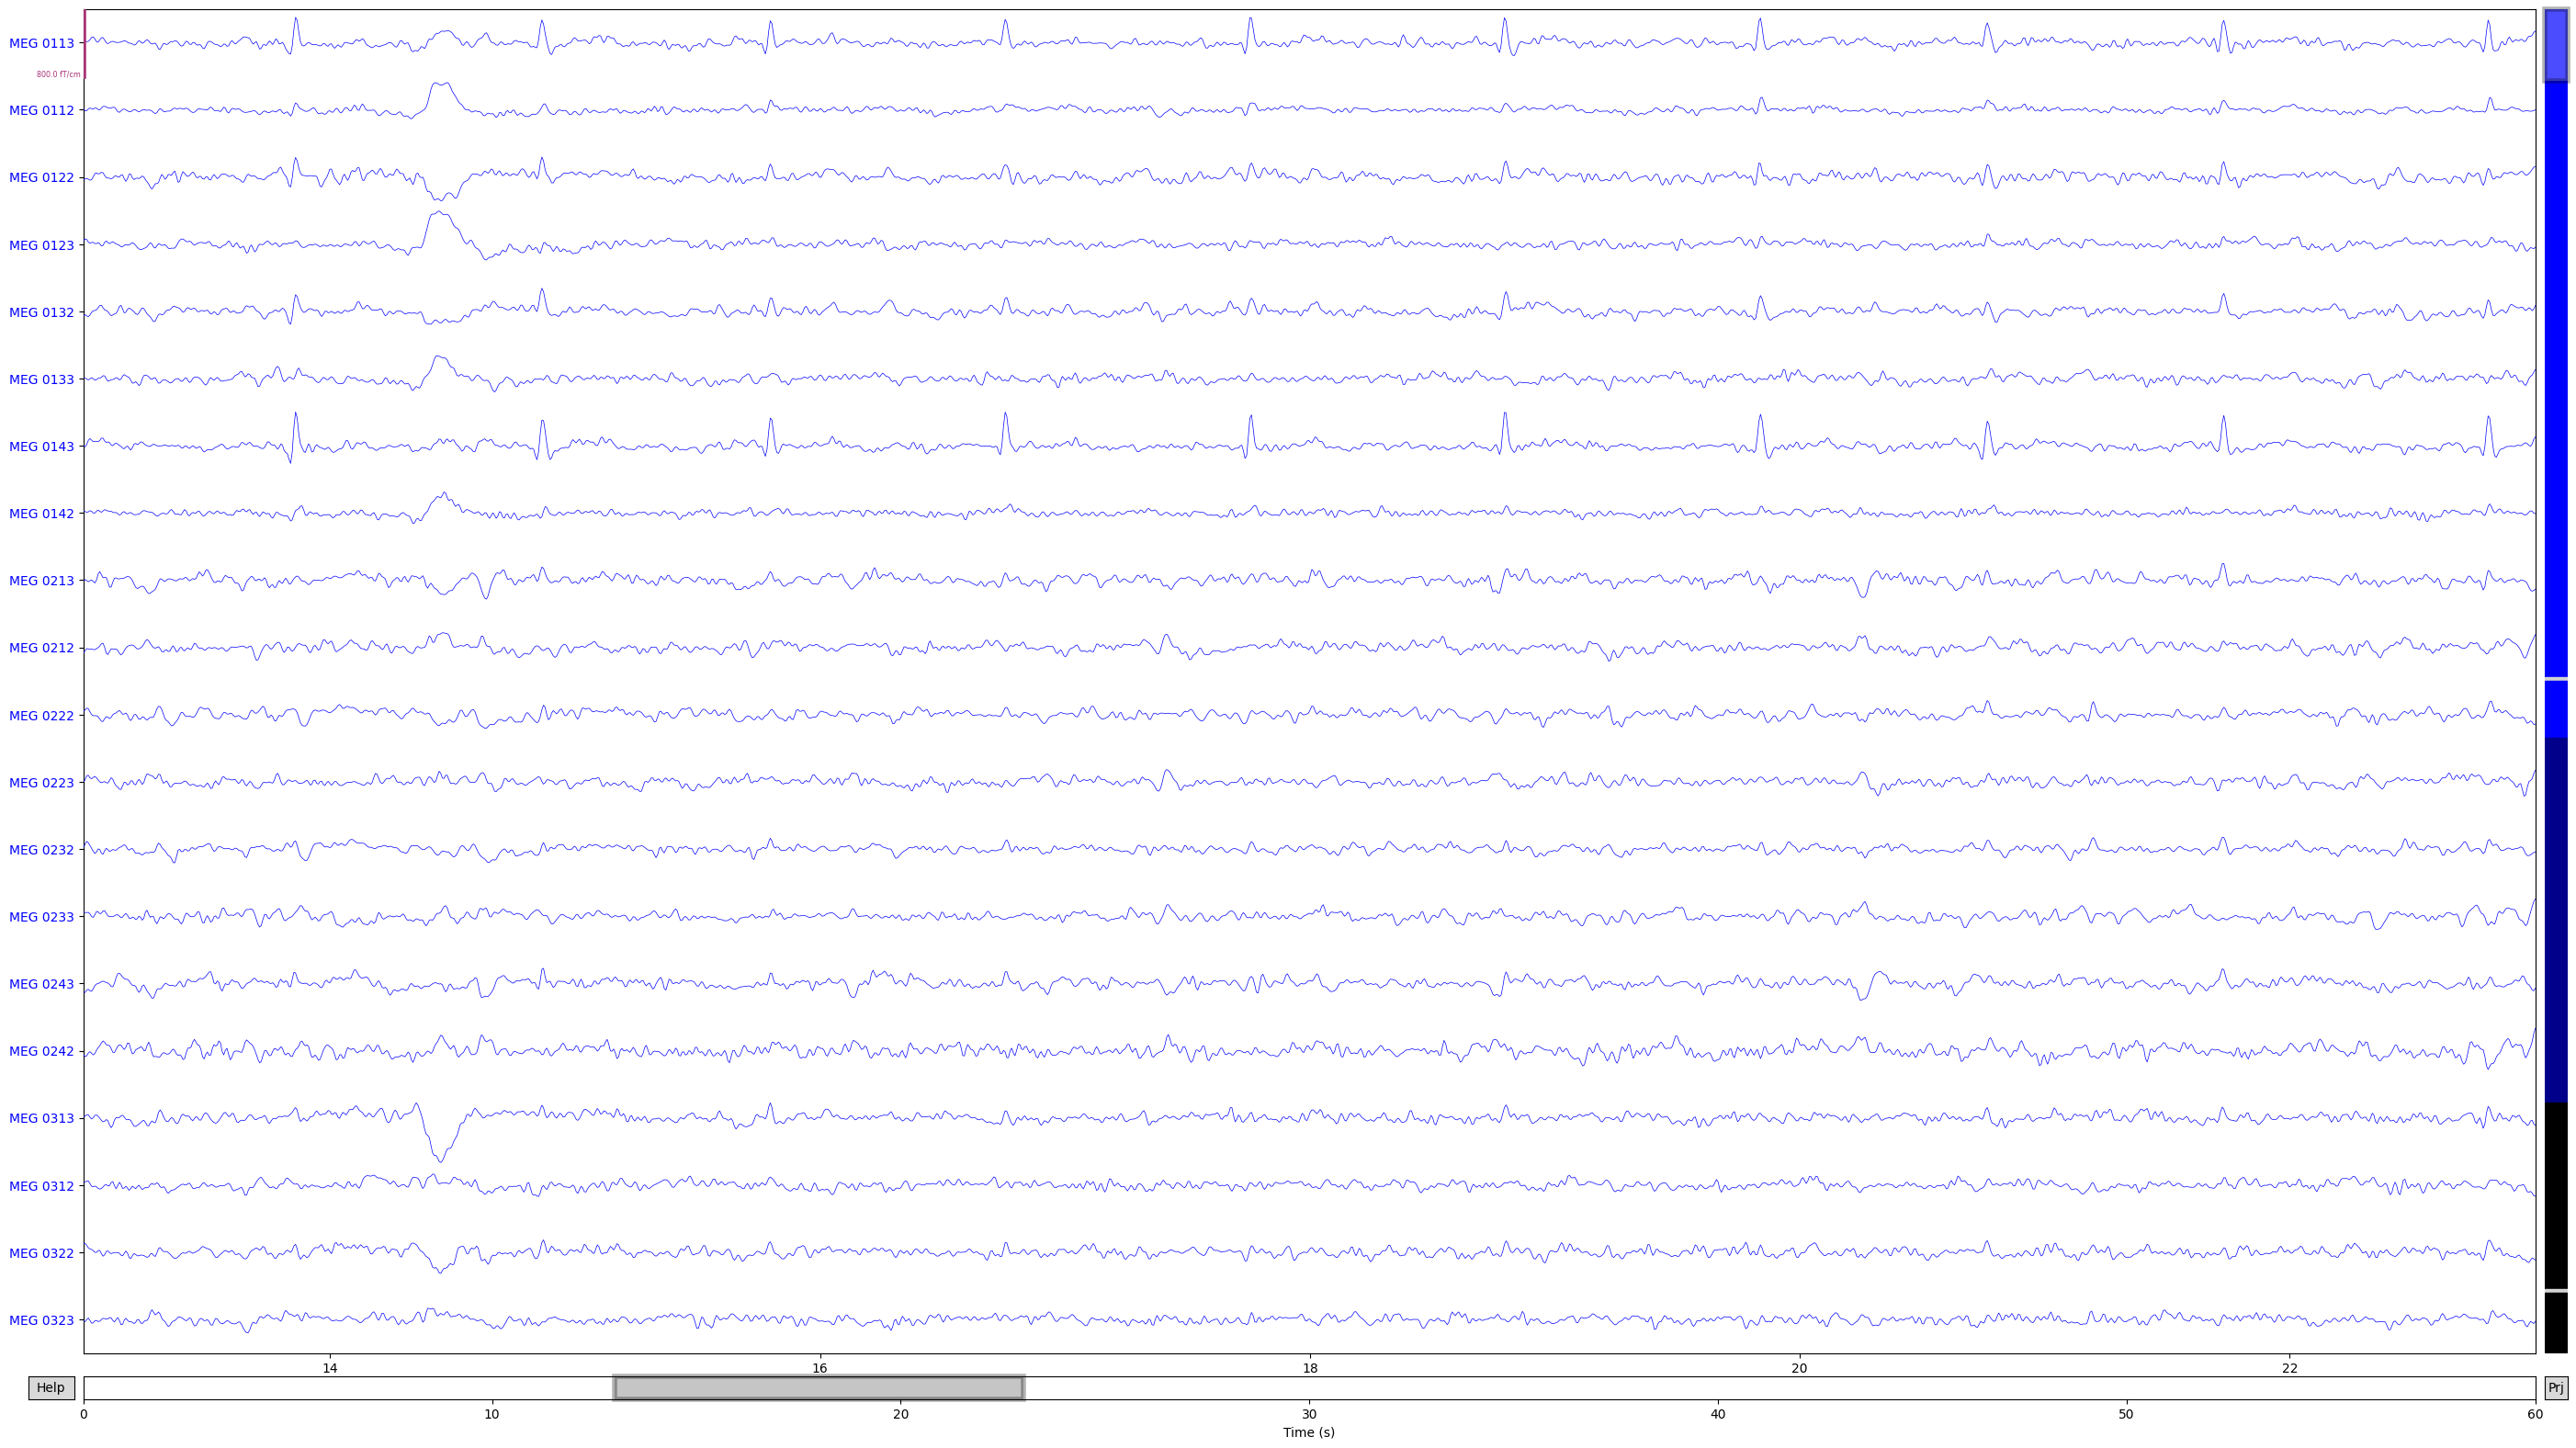

In [8]:
fig = old_raw.plot(start=13)

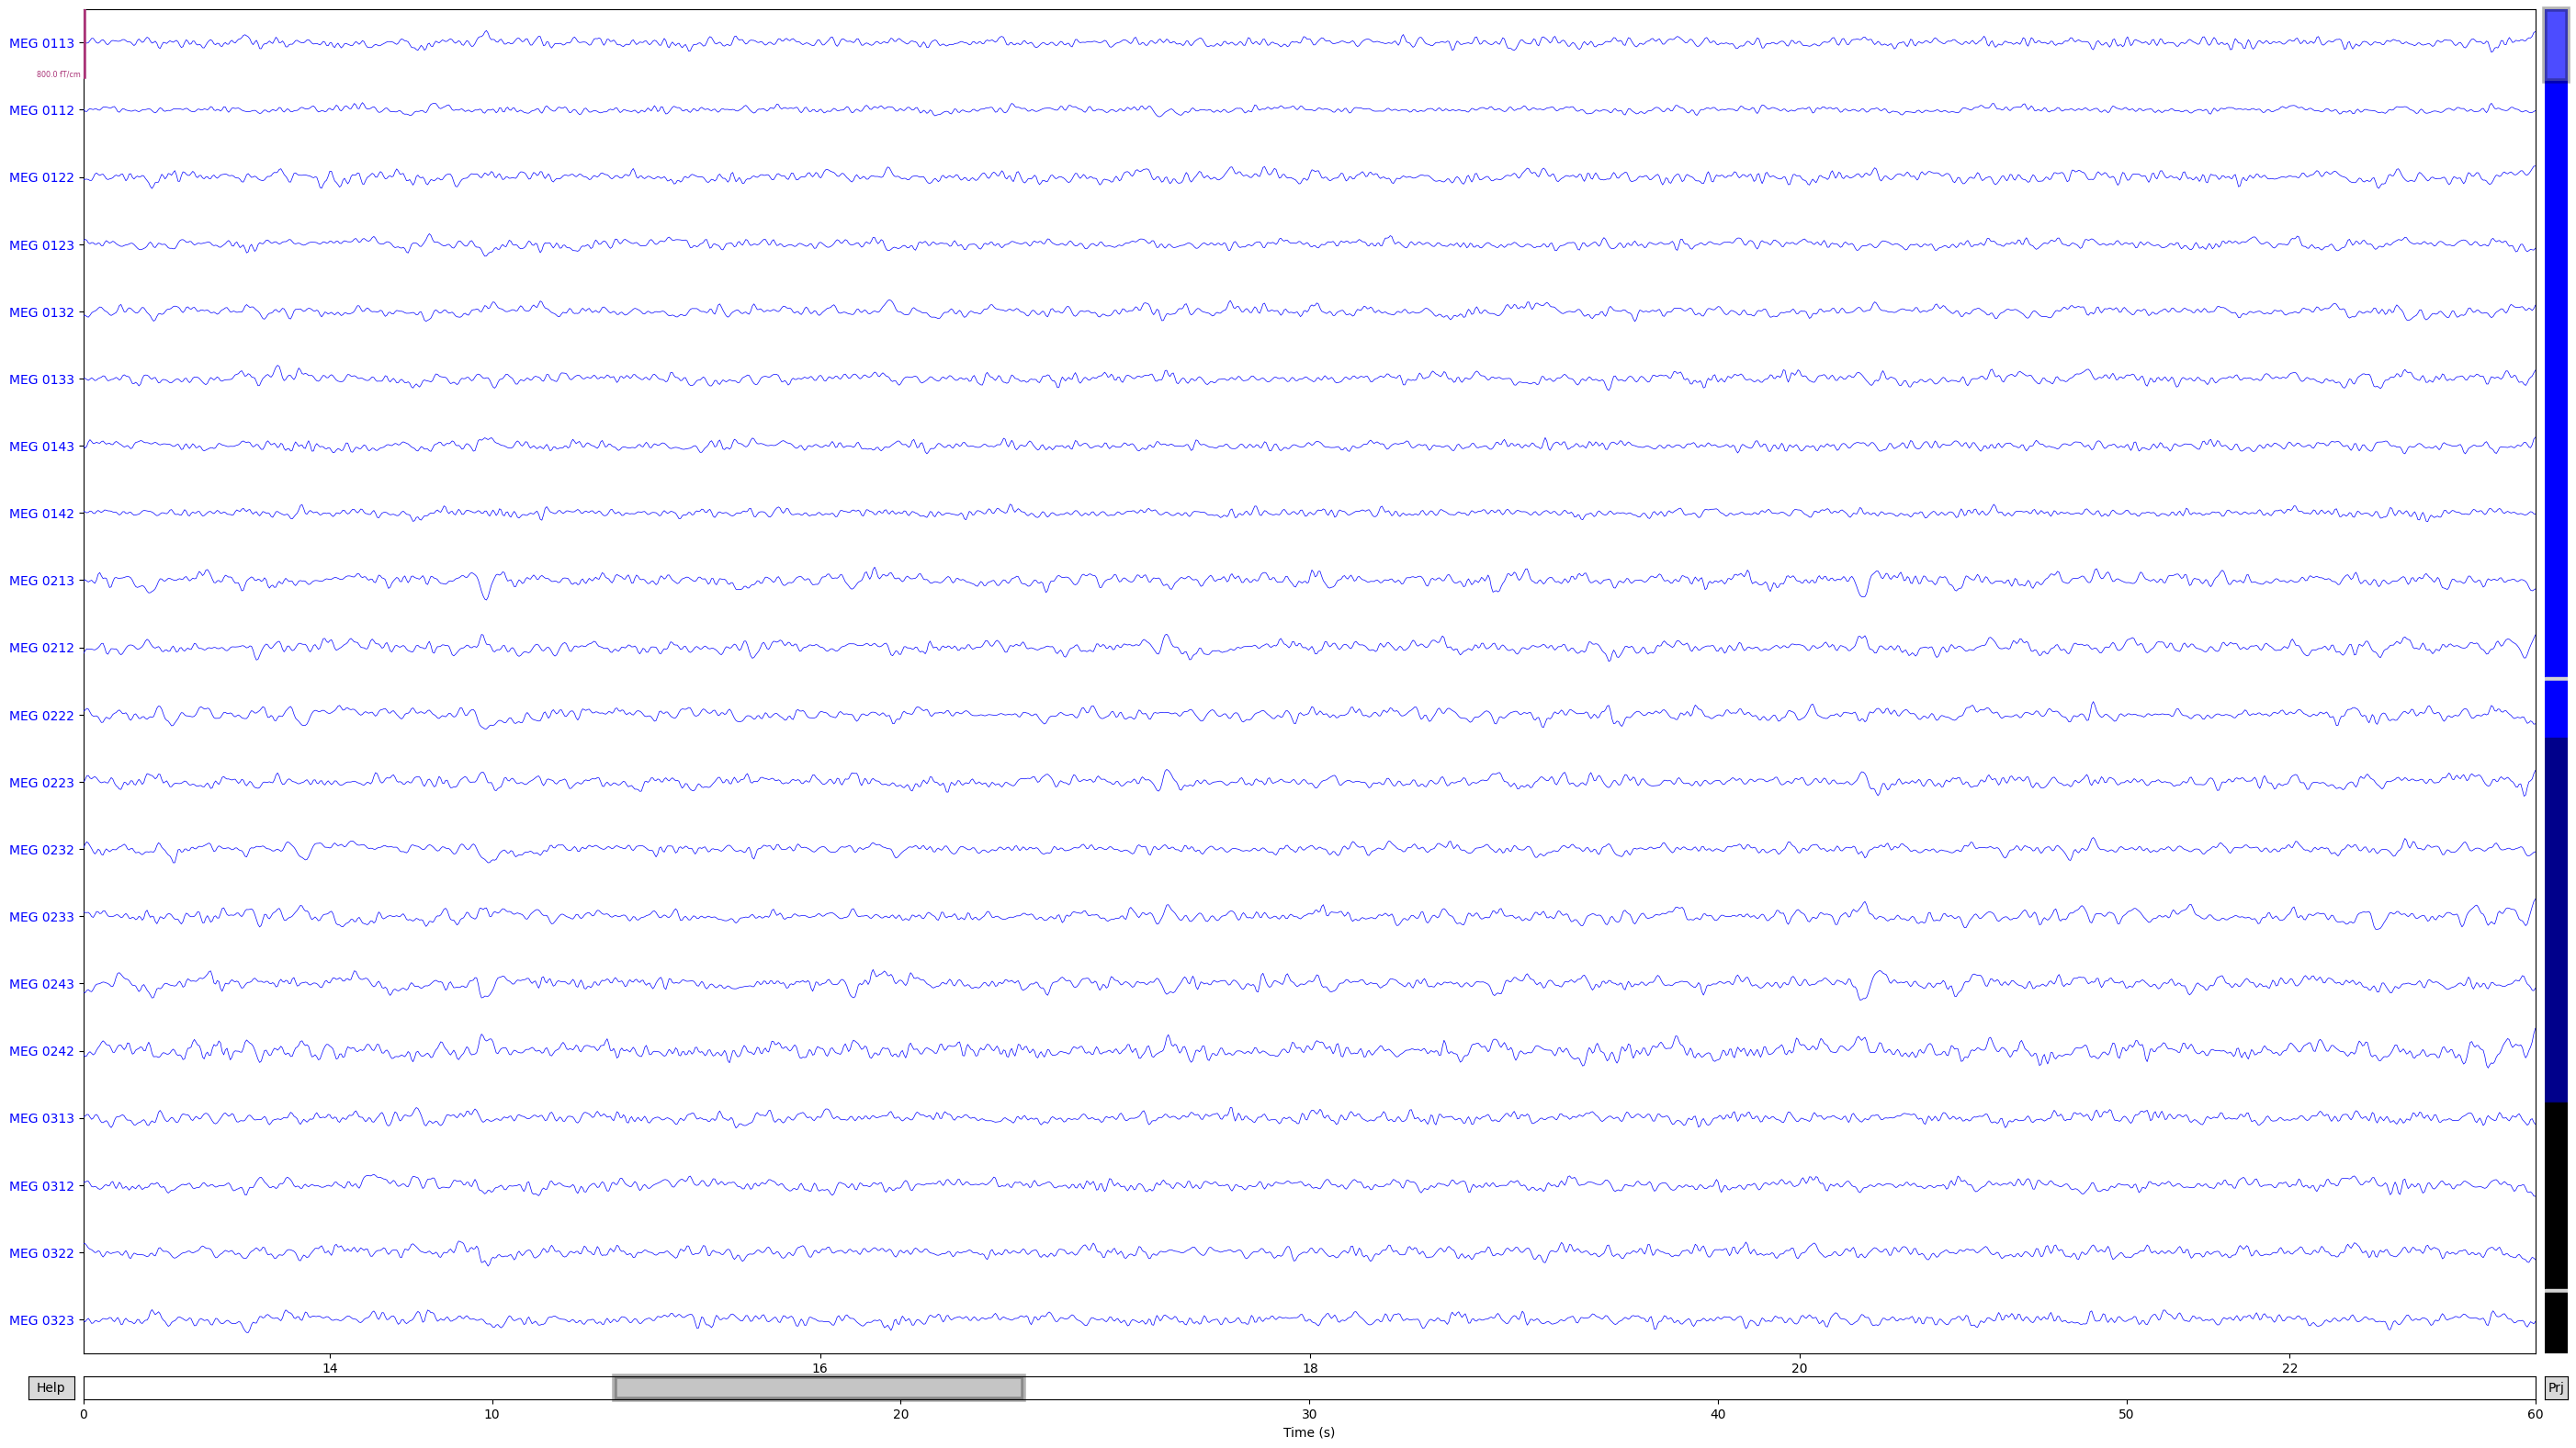

In [9]:
fig = raw.plot(start=13)

If you compare the reconstructed (bottom) with the original (top), it is clear that the blinks and heartbeats are gone, but everything else appears to be intact!

---
## Automatic component selection
We selected the components by hand above, but if you have EOG channel(s), it is possible to do it automatically, and this usually produces very good results. We start first with EOG.

In [10]:
eog_bads, eog_scores = ica.find_bads_eog(old_raw)
print(f"Bad EOG components are {eog_bads}")

Using EOG channel: EOG 061
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1502 samples (10.003 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


It identified component 0, and only 0, just as we did. Now let's try ECG.

In [11]:
ecg_bads, ecg_scores = ica.find_bads_ecg(old_raw)
print(f"Bad ECG components are {ecg_bads}")

Reconstructing ECG signal from Magnetometers
Using threshold: 0.41 for CTPS ECG detection
Reconstructing ECG signal from Magnetometers
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 1502 samples (10.003 s)

Number of ECG events detected : 59 (average pulse 58 / min.)
Not setting metadata
59 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 4)
Using data from preloaded Raw for 59 events and 151 original time points ...
0 bad epochs dropped
Bad ECG components are [11, 1]


It identified component 1, as we did, but also component 10. We only looked at components 0-7, so let's have a quick look at component 10 using the handy plot_properties method.

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated


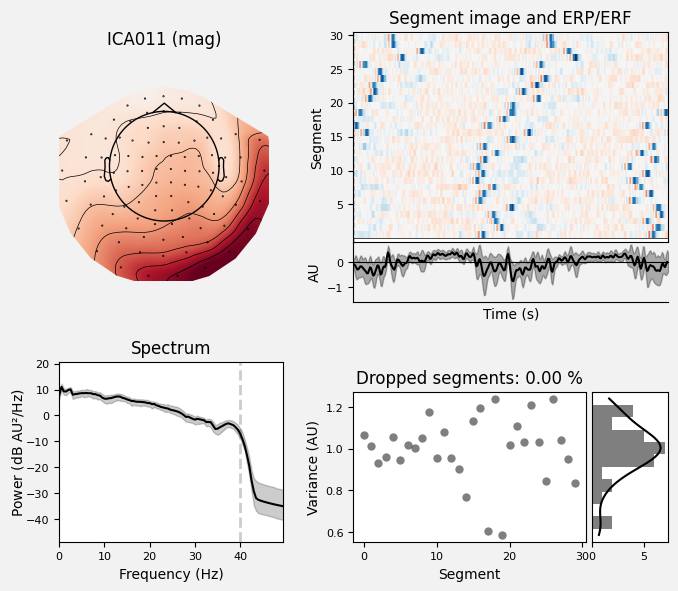

[<Figure size 700x600 with 6 Axes>]

In [12]:
ica.plot_properties(old_raw, 11)

This does indeed look like a heartbeat-related component (note especially the regular, sharp dots in the top right graph), so we would also want to exclude component 10 with reconstruction as well.